<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/c4_w3_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from tensorflow.keras.backend import clear_session
from tensorflow.random import set_seed
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Lambda, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import mean_absolute_error

tf.__version__

'2.4.0'

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
trend_series = trend(time, slope)
seasonality_series = seasonality(time, period=365, amplitude=amplitude)
noise_series = noise(time, noise_level, seed=42)
series = baseline + trend_series + seasonality_series + noise_series

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(
        lambda window: (window[:-1], window[-1])
    )
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
clear_session()
set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(
    x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size
)

In [7]:
seq, label = next(iter(train_set.take(1)))
seq.shape, label.shape

(TensorShape([32, 20]), TensorShape([32]))

In [8]:
def create_model():
    return Sequential([
        Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(1),
        Lambda(lambda x: x * 100.0)
    ])

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         33792     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 132,737
Trainable params: 132,737
Non-trainable params: 0
_________________________________________________________________


In [9]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
model.compile(loss=Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 7s 12ms/step - loss: 20.1233 - mae: 20.6217
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 19.4844 - mae: 19.9821
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 19.8947 - mae: 20.3913
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 19.6282 - mae: 20.1265
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 19.0878 - mae: 19.5858
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 18.3820 - mae: 18.8783
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 17.4888 - mae: 17.9859
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 17.4690 - mae: 17.9631
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 16.9286 - mae: 17.4251
Epoch 10/100
31/31 [==============================] - 0s 11ms/step - loss: 16.3646 - mae: 16.8575
Epoch 11/100
31/31 [=========

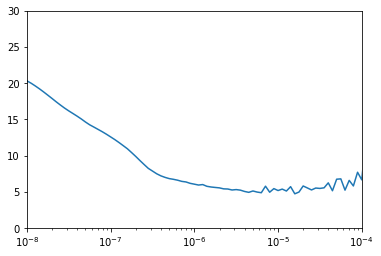

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30]);

In [20]:
clear_session()
set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(
    x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size
)
model = create_model()
optimizer = SGD(lr=1e-6, momentum=0.9)
model.compile(loss=Huber(), optimizer="adam", metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 5s 11ms/step - loss: 20.9568 - mae: 21.4546
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 20.1564 - mae: 20.6551
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 19.7972 - mae: 20.2953
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 20.5847 - mae: 21.0828
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 20.7784 - mae: 21.2768
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 20.6134 - mae: 21.1095
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 20.2178 - mae: 20.7154
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 19.8774 - mae: 20.3734
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 20.3247 - mae: 20.8221
Epoch 10/100
31/31 [==============================] - 0s 11ms/step - loss: 20.2040 - mae: 20.7026
Epoch 11/100
31/31 [=========

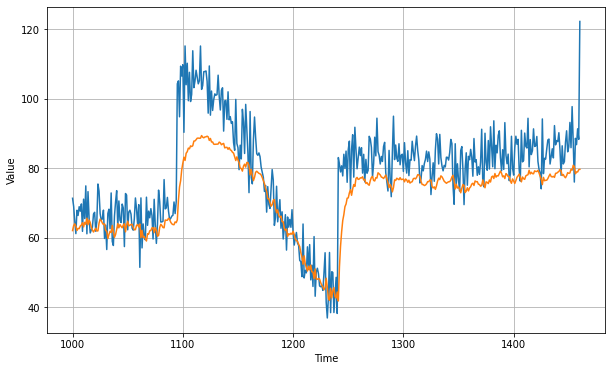

In [21]:
forecast = []
for time in range(len(series) - window_size):
    pred = model.predict(series[time:time+window_size][np.newaxis])
    forecast.append(pred)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)


Epoch 1/100
31/31 [==============================] - 5s 10ms/step - loss: 21.4546 - mae: 21.4546
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 20.6550 - mae: 20.6550
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 20.2953 - mae: 20.2953
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 21.0828 - mae: 21.0828
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 21.2768 - mae: 21.2768
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 21.1094 - mae: 21.1094
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 20.7153 - mae: 20.7153
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 20.3733 - mae: 20.3733
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 20.8221 - mae: 20.8221
Epoch 10/100
31/31 [==============================] - 0s 10ms/step - loss: 20.7026 - mae: 20.7026
Epoch 11/100
31/31 [=========

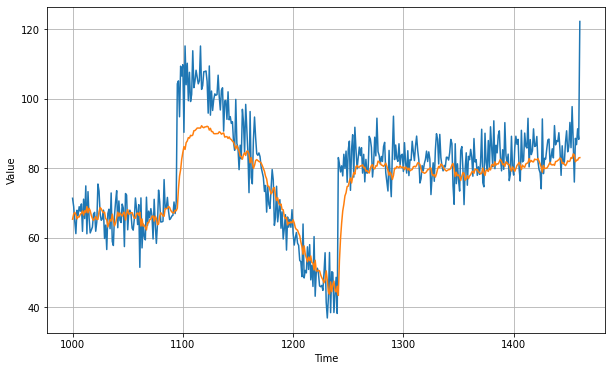

In [24]:
clear_session()
set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(
    x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size
)
model = create_model()
optimizer = SGD(lr=1e-6, momentum=0.9)
model.compile(loss="mae", optimizer="adam", metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

forecast = []
for time in range(len(series) - window_size):
    pred = model.predict(series[time:time+window_size][np.newaxis])
    forecast.append(pred)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [25]:
mean_absolute_error(x_valid, results).numpy()

6.057719

<Figure size 432x288 with 0 Axes>

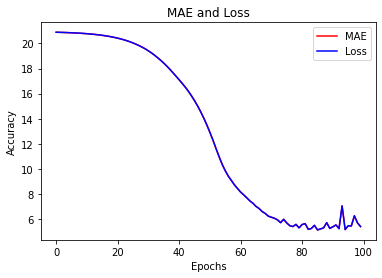

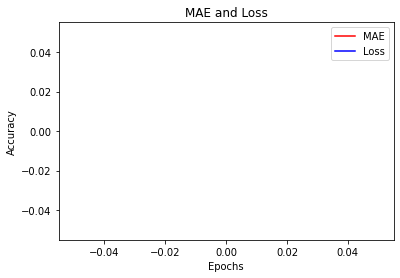

<Figure size 432x288 with 0 Axes>

In [27]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()